# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

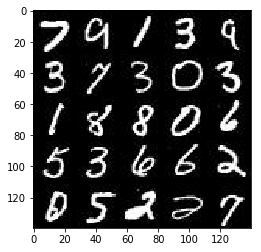

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

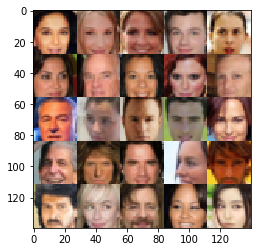

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(None), name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Leaky Relu
Defining a leaky relu function I can reuse in the notebook here

In [6]:
def leaky_relu(x, alpha=0.2, name='leaky_relu'): 
    return tf.maximum(x, alpha * x, name=name)

### kernel initializer
Shortcut for xavier_initializer for the conv2d layers

In [7]:
xavier = tf.contrib.layers.xavier_initializer_conv2d

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        l1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=xavier())
        relu1 = leaky_relu(l1)
        
        l2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=xavier())
        bn2 = tf.layers.batch_normalization(l2, training=True)
        relu2 = leaky_relu(bn2)
        
        l3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=xavier())
        bn3 = tf.layers.batch_normalization(l3, training=True)
        relu3 = leaky_relu(bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):

        l1 = tf.layers.dense(z, 4*4*512)
        l1 = tf.reshape(l1, (-1, 4, 4, 512))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = leaky_relu(l1)
        # 4x4x512 now
        
        l2 = tf.layers.conv2d_transpose(l1, 256, 4, strides=1, padding='valid', kernel_initializer=xavier())
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = leaky_relu(l2)
        # 7x7x256 now
        
        l3 = tf.layers.conv2d_transpose(l2, 128, 5, strides=2, padding='same', kernel_initializer=xavier())
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = leaky_relu(l3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(l3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # adding label smoothing
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1.0 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    total_data_size, image_width, image_height, image_channels = data_shape

    input_real, input_z, learning_rate_input = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Generate random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # rescale images to be between -1 and 1
                batch_images = batch_images * 2
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, 
                                               learning_rate_input: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images,
                                               learning_rate_input: learning_rate})
                # My first submission didn't generate good pictures because after about 60-70 batches the
                # discriminator's loss would get very small, and the generator's loss would start increasing.
                # I suspect what happened is the discriminator was "too good" and the generator was no longer
                # able to learn what would pass for a real image so it couldn't improve. I added extra runs
                # so the generator would be able to learn as quickly and compete better with the discriminator.
                # The generator loss became much more stable, and the you can now see the losses alternating as
                # the discriminator and generator compete to make each other better, particularly on the mnist data.
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images,
                                               learning_rate_input: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} Batch Step {}...".format(epoch_i, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 20, input_z, image_channels, data_image_mode)
                
        print('Done Training!')
        show_generator_output(sess, 20, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2 Batch Step 10... Discriminator Loss: 2.7633... Generator Loss: 0.1232
Epoch 0/2 Batch Step 20... Discriminator Loss: 2.2159... Generator Loss: 0.2606
Epoch 0/2 Batch Step 30... Discriminator Loss: 2.3539... Generator Loss: 0.2341
Epoch 0/2 Batch Step 40... Discriminator Loss: 2.5981... Generator Loss: 0.2752
Epoch 0/2 Batch Step 50... Discriminator Loss: 2.2689... Generator Loss: 0.3702
Epoch 0/2 Batch Step 60... Discriminator Loss: 1.8823... Generator Loss: 0.4380
Epoch 0/2 Batch Step 70... Discriminator Loss: 1.5190... Generator Loss: 0.6197
Epoch 0/2 Batch Step 80... Discriminator Loss: 1.1343... Generator Loss: 1.0065
Epoch 0/2 Batch Step 90... Discriminator Loss: 1.0677... Generator Loss: 0.9296
Epoch 0/2 Batch Step 100... Discriminator Loss: 1.1908... Generator Loss: 0.7963


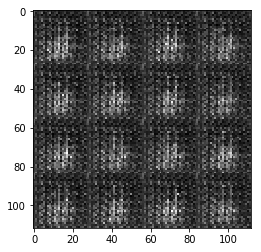

Epoch 0/2 Batch Step 110... Discriminator Loss: 1.1995... Generator Loss: 1.0770
Epoch 0/2 Batch Step 120... Discriminator Loss: 1.0603... Generator Loss: 0.9781
Epoch 0/2 Batch Step 130... Discriminator Loss: 0.9219... Generator Loss: 1.1977
Epoch 0/2 Batch Step 140... Discriminator Loss: 0.9971... Generator Loss: 1.0472
Epoch 0/2 Batch Step 150... Discriminator Loss: 0.6701... Generator Loss: 1.5858
Epoch 0/2 Batch Step 160... Discriminator Loss: 0.7787... Generator Loss: 1.5596
Epoch 0/2 Batch Step 170... Discriminator Loss: 1.2196... Generator Loss: 0.8350
Epoch 0/2 Batch Step 180... Discriminator Loss: 1.4158... Generator Loss: 0.8947
Epoch 0/2 Batch Step 190... Discriminator Loss: 1.5386... Generator Loss: 0.7772
Epoch 0/2 Batch Step 200... Discriminator Loss: 1.2801... Generator Loss: 0.9473


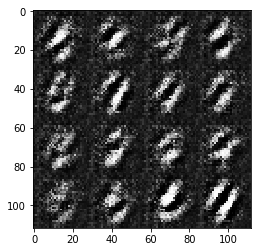

Epoch 0/2 Batch Step 210... Discriminator Loss: 1.1760... Generator Loss: 0.9535
Epoch 0/2 Batch Step 220... Discriminator Loss: 1.1628... Generator Loss: 0.9529
Epoch 0/2 Batch Step 230... Discriminator Loss: 1.0240... Generator Loss: 1.0828
Epoch 0/2 Batch Step 240... Discriminator Loss: 0.9572... Generator Loss: 1.1462
Epoch 0/2 Batch Step 250... Discriminator Loss: 1.1244... Generator Loss: 0.9248
Epoch 0/2 Batch Step 260... Discriminator Loss: 1.1850... Generator Loss: 0.9313
Epoch 0/2 Batch Step 270... Discriminator Loss: 1.1938... Generator Loss: 0.9756
Epoch 0/2 Batch Step 280... Discriminator Loss: 1.2292... Generator Loss: 0.9589
Epoch 0/2 Batch Step 290... Discriminator Loss: 1.2821... Generator Loss: 0.8509
Epoch 0/2 Batch Step 300... Discriminator Loss: 1.2629... Generator Loss: 0.8509


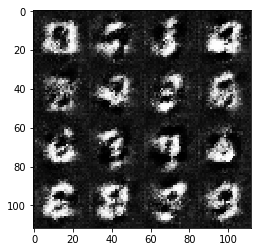

Epoch 0/2 Batch Step 310... Discriminator Loss: 1.2940... Generator Loss: 0.8163
Epoch 0/2 Batch Step 320... Discriminator Loss: 1.3507... Generator Loss: 0.8292
Epoch 0/2 Batch Step 330... Discriminator Loss: 1.3099... Generator Loss: 0.8581
Epoch 0/2 Batch Step 340... Discriminator Loss: 1.2031... Generator Loss: 0.8911
Epoch 0/2 Batch Step 350... Discriminator Loss: 1.1808... Generator Loss: 0.9592
Epoch 0/2 Batch Step 360... Discriminator Loss: 1.2838... Generator Loss: 0.9065
Epoch 0/2 Batch Step 370... Discriminator Loss: 1.1340... Generator Loss: 0.9069
Epoch 0/2 Batch Step 380... Discriminator Loss: 1.0529... Generator Loss: 1.0192
Epoch 0/2 Batch Step 390... Discriminator Loss: 1.2274... Generator Loss: 0.8635
Epoch 0/2 Batch Step 400... Discriminator Loss: 1.1553... Generator Loss: 0.8667


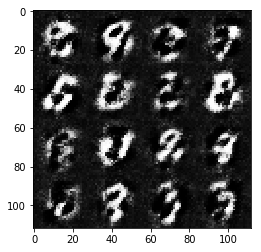

Epoch 0/2 Batch Step 410... Discriminator Loss: 1.1759... Generator Loss: 0.9058
Epoch 0/2 Batch Step 420... Discriminator Loss: 1.2292... Generator Loss: 0.8550
Epoch 0/2 Batch Step 430... Discriminator Loss: 1.0601... Generator Loss: 1.0161
Epoch 0/2 Batch Step 440... Discriminator Loss: 1.1003... Generator Loss: 0.8739
Epoch 0/2 Batch Step 450... Discriminator Loss: 0.9924... Generator Loss: 1.1242
Epoch 0/2 Batch Step 460... Discriminator Loss: 1.0576... Generator Loss: 1.0714
Epoch 0/2 Batch Step 470... Discriminator Loss: 1.1546... Generator Loss: 0.8932
Epoch 0/2 Batch Step 480... Discriminator Loss: 1.1212... Generator Loss: 0.9193
Epoch 0/2 Batch Step 490... Discriminator Loss: 1.0861... Generator Loss: 0.9770
Epoch 0/2 Batch Step 500... Discriminator Loss: 1.0889... Generator Loss: 0.9434


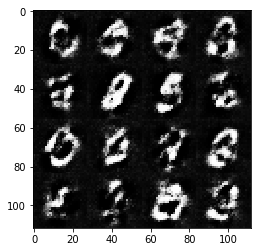

Epoch 0/2 Batch Step 510... Discriminator Loss: 1.0915... Generator Loss: 1.0672
Epoch 0/2 Batch Step 520... Discriminator Loss: 1.0942... Generator Loss: 0.9443
Epoch 0/2 Batch Step 530... Discriminator Loss: 1.1303... Generator Loss: 1.0730
Epoch 0/2 Batch Step 540... Discriminator Loss: 1.0534... Generator Loss: 1.1208
Epoch 0/2 Batch Step 550... Discriminator Loss: 1.0402... Generator Loss: 1.0819
Epoch 0/2 Batch Step 560... Discriminator Loss: 1.0022... Generator Loss: 1.0955
Epoch 0/2 Batch Step 570... Discriminator Loss: 0.9931... Generator Loss: 1.3428
Epoch 0/2 Batch Step 580... Discriminator Loss: 0.9942... Generator Loss: 0.9646
Epoch 0/2 Batch Step 590... Discriminator Loss: 1.0269... Generator Loss: 1.0777
Epoch 0/2 Batch Step 600... Discriminator Loss: 1.0423... Generator Loss: 0.9280


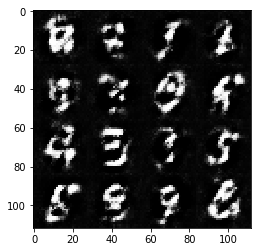

Epoch 0/2 Batch Step 610... Discriminator Loss: 1.0597... Generator Loss: 1.2340
Epoch 0/2 Batch Step 620... Discriminator Loss: 1.0762... Generator Loss: 1.2131
Epoch 0/2 Batch Step 630... Discriminator Loss: 1.0267... Generator Loss: 0.9299
Epoch 0/2 Batch Step 640... Discriminator Loss: 0.9521... Generator Loss: 1.0827
Epoch 0/2 Batch Step 650... Discriminator Loss: 1.0106... Generator Loss: 1.0636
Epoch 0/2 Batch Step 660... Discriminator Loss: 1.0243... Generator Loss: 0.9617
Epoch 0/2 Batch Step 670... Discriminator Loss: 1.0879... Generator Loss: 0.8476
Epoch 0/2 Batch Step 680... Discriminator Loss: 0.9694... Generator Loss: 1.0283
Epoch 0/2 Batch Step 690... Discriminator Loss: 1.0434... Generator Loss: 0.9468
Epoch 0/2 Batch Step 700... Discriminator Loss: 1.0078... Generator Loss: 1.2298


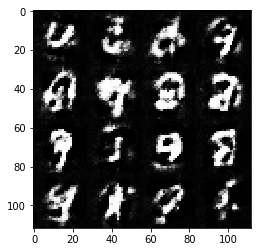

Epoch 0/2 Batch Step 710... Discriminator Loss: 1.1055... Generator Loss: 0.8936
Epoch 0/2 Batch Step 720... Discriminator Loss: 0.9964... Generator Loss: 1.0629
Epoch 0/2 Batch Step 730... Discriminator Loss: 0.9711... Generator Loss: 1.0862
Epoch 0/2 Batch Step 740... Discriminator Loss: 0.9494... Generator Loss: 1.3066
Epoch 0/2 Batch Step 750... Discriminator Loss: 0.8992... Generator Loss: 1.2726
Epoch 0/2 Batch Step 760... Discriminator Loss: 1.0033... Generator Loss: 1.1643
Epoch 0/2 Batch Step 770... Discriminator Loss: 0.9582... Generator Loss: 1.1452
Epoch 0/2 Batch Step 780... Discriminator Loss: 1.1386... Generator Loss: 0.7278
Epoch 0/2 Batch Step 790... Discriminator Loss: 1.0514... Generator Loss: 1.1252
Epoch 0/2 Batch Step 800... Discriminator Loss: 1.0393... Generator Loss: 1.0325


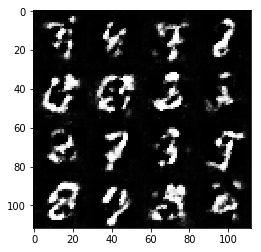

Epoch 0/2 Batch Step 810... Discriminator Loss: 1.0891... Generator Loss: 0.7391
Epoch 0/2 Batch Step 820... Discriminator Loss: 0.8778... Generator Loss: 1.0658
Epoch 0/2 Batch Step 830... Discriminator Loss: 1.0805... Generator Loss: 0.8728
Epoch 0/2 Batch Step 840... Discriminator Loss: 1.0691... Generator Loss: 0.8509
Epoch 0/2 Batch Step 850... Discriminator Loss: 0.9644... Generator Loss: 1.2233
Epoch 0/2 Batch Step 860... Discriminator Loss: 1.1181... Generator Loss: 0.8728
Epoch 0/2 Batch Step 870... Discriminator Loss: 0.9419... Generator Loss: 1.2499
Epoch 0/2 Batch Step 880... Discriminator Loss: 1.0162... Generator Loss: 0.9270
Epoch 0/2 Batch Step 890... Discriminator Loss: 0.9487... Generator Loss: 0.9794
Epoch 0/2 Batch Step 900... Discriminator Loss: 0.9417... Generator Loss: 1.1269


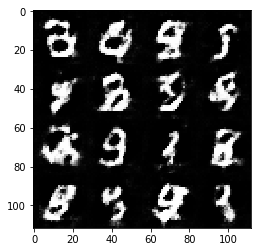

Epoch 0/2 Batch Step 910... Discriminator Loss: 0.9962... Generator Loss: 1.2768
Epoch 0/2 Batch Step 920... Discriminator Loss: 1.0019... Generator Loss: 1.0100
Epoch 0/2 Batch Step 930... Discriminator Loss: 1.0768... Generator Loss: 0.8832
Epoch 0/2 Batch Step 940... Discriminator Loss: 1.0234... Generator Loss: 0.8473
Epoch 0/2 Batch Step 950... Discriminator Loss: 1.0345... Generator Loss: 0.8476
Epoch 0/2 Batch Step 960... Discriminator Loss: 1.0414... Generator Loss: 1.0562
Epoch 0/2 Batch Step 970... Discriminator Loss: 1.1834... Generator Loss: 0.6659
Epoch 0/2 Batch Step 980... Discriminator Loss: 1.0655... Generator Loss: 0.8365
Epoch 0/2 Batch Step 990... Discriminator Loss: 1.0399... Generator Loss: 0.9708
Epoch 0/2 Batch Step 1000... Discriminator Loss: 1.1131... Generator Loss: 0.7385


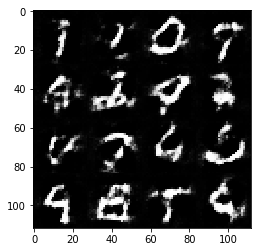

Epoch 0/2 Batch Step 1010... Discriminator Loss: 0.9607... Generator Loss: 1.1204
Epoch 0/2 Batch Step 1020... Discriminator Loss: 1.0500... Generator Loss: 0.8820
Epoch 0/2 Batch Step 1030... Discriminator Loss: 0.9463... Generator Loss: 1.3095
Epoch 0/2 Batch Step 1040... Discriminator Loss: 1.1144... Generator Loss: 0.7894
Epoch 0/2 Batch Step 1050... Discriminator Loss: 1.1696... Generator Loss: 1.0814
Epoch 0/2 Batch Step 1060... Discriminator Loss: 1.0017... Generator Loss: 0.9968
Epoch 0/2 Batch Step 1070... Discriminator Loss: 1.1684... Generator Loss: 0.7181
Epoch 0/2 Batch Step 1080... Discriminator Loss: 1.1200... Generator Loss: 0.9325
Epoch 0/2 Batch Step 1090... Discriminator Loss: 1.5581... Generator Loss: 0.3847
Epoch 0/2 Batch Step 1100... Discriminator Loss: 1.4170... Generator Loss: 0.6048


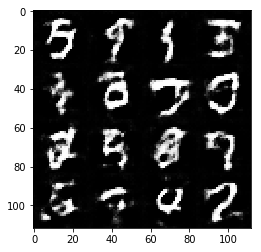

Epoch 0/2 Batch Step 1110... Discriminator Loss: 1.2629... Generator Loss: 0.7090
Epoch 0/2 Batch Step 1120... Discriminator Loss: 1.1013... Generator Loss: 0.8181
Epoch 0/2 Batch Step 1130... Discriminator Loss: 1.0804... Generator Loss: 0.8097
Epoch 0/2 Batch Step 1140... Discriminator Loss: 1.1120... Generator Loss: 0.9403
Epoch 0/2 Batch Step 1150... Discriminator Loss: 1.1159... Generator Loss: 1.3604
Epoch 0/2 Batch Step 1160... Discriminator Loss: 1.0894... Generator Loss: 0.7826
Epoch 0/2 Batch Step 1170... Discriminator Loss: 1.1397... Generator Loss: 1.6662
Epoch 0/2 Batch Step 1180... Discriminator Loss: 1.1361... Generator Loss: 0.8925
Epoch 0/2 Batch Step 1190... Discriminator Loss: 1.0979... Generator Loss: 0.9184
Epoch 0/2 Batch Step 1200... Discriminator Loss: 1.1029... Generator Loss: 0.8634


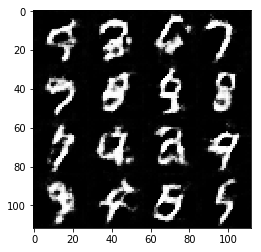

Epoch 0/2 Batch Step 1210... Discriminator Loss: 1.2448... Generator Loss: 1.1117
Epoch 0/2 Batch Step 1220... Discriminator Loss: 1.2035... Generator Loss: 0.6790
Epoch 0/2 Batch Step 1230... Discriminator Loss: 1.2233... Generator Loss: 0.7478
Epoch 0/2 Batch Step 1240... Discriminator Loss: 1.1252... Generator Loss: 1.4138
Epoch 0/2 Batch Step 1250... Discriminator Loss: 1.2869... Generator Loss: 0.6306
Epoch 0/2 Batch Step 1260... Discriminator Loss: 1.2480... Generator Loss: 0.7110
Epoch 0/2 Batch Step 1270... Discriminator Loss: 1.1632... Generator Loss: 0.9443
Epoch 0/2 Batch Step 1280... Discriminator Loss: 1.0868... Generator Loss: 1.1361
Epoch 0/2 Batch Step 1290... Discriminator Loss: 1.1643... Generator Loss: 0.7407
Epoch 0/2 Batch Step 1300... Discriminator Loss: 1.0798... Generator Loss: 1.0754


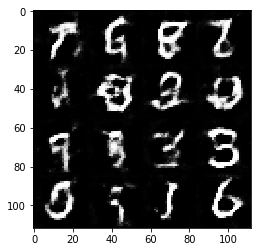

Epoch 0/2 Batch Step 1310... Discriminator Loss: 1.3061... Generator Loss: 0.6439
Epoch 0/2 Batch Step 1320... Discriminator Loss: 1.1775... Generator Loss: 0.7978
Epoch 0/2 Batch Step 1330... Discriminator Loss: 1.1748... Generator Loss: 0.9287
Epoch 0/2 Batch Step 1340... Discriminator Loss: 1.2079... Generator Loss: 0.7919
Epoch 0/2 Batch Step 1350... Discriminator Loss: 1.4206... Generator Loss: 0.4768
Epoch 0/2 Batch Step 1360... Discriminator Loss: 1.2654... Generator Loss: 0.5561
Epoch 0/2 Batch Step 1370... Discriminator Loss: 1.0698... Generator Loss: 1.1149
Epoch 0/2 Batch Step 1380... Discriminator Loss: 1.2358... Generator Loss: 0.7935
Epoch 0/2 Batch Step 1390... Discriminator Loss: 1.2658... Generator Loss: 0.6655
Epoch 0/2 Batch Step 1400... Discriminator Loss: 1.2550... Generator Loss: 0.6680


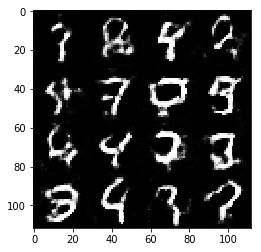

Epoch 0/2 Batch Step 1410... Discriminator Loss: 1.1743... Generator Loss: 1.0245
Epoch 0/2 Batch Step 1420... Discriminator Loss: 1.1301... Generator Loss: 0.8496
Epoch 0/2 Batch Step 1430... Discriminator Loss: 1.0797... Generator Loss: 0.8465
Epoch 0/2 Batch Step 1440... Discriminator Loss: 1.1999... Generator Loss: 0.8900
Epoch 0/2 Batch Step 1450... Discriminator Loss: 1.1036... Generator Loss: 0.7240
Epoch 0/2 Batch Step 1460... Discriminator Loss: 1.1532... Generator Loss: 0.8972
Epoch 0/2 Batch Step 1470... Discriminator Loss: 1.1850... Generator Loss: 0.7155
Epoch 0/2 Batch Step 1480... Discriminator Loss: 1.1377... Generator Loss: 0.8949
Epoch 0/2 Batch Step 1490... Discriminator Loss: 1.1541... Generator Loss: 0.7810
Epoch 0/2 Batch Step 1500... Discriminator Loss: 1.1416... Generator Loss: 0.7747


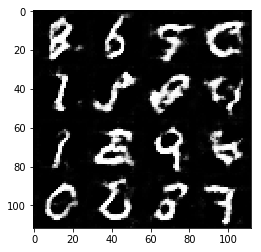

Epoch 0/2 Batch Step 1510... Discriminator Loss: 1.1829... Generator Loss: 0.7969
Epoch 0/2 Batch Step 1520... Discriminator Loss: 1.0633... Generator Loss: 1.0144
Epoch 0/2 Batch Step 1530... Discriminator Loss: 1.2923... Generator Loss: 0.6741
Epoch 0/2 Batch Step 1540... Discriminator Loss: 1.2549... Generator Loss: 0.9350
Epoch 0/2 Batch Step 1550... Discriminator Loss: 1.2054... Generator Loss: 0.7507
Epoch 0/2 Batch Step 1560... Discriminator Loss: 1.0318... Generator Loss: 1.1744
Epoch 0/2 Batch Step 1570... Discriminator Loss: 1.0969... Generator Loss: 0.9872
Epoch 0/2 Batch Step 1580... Discriminator Loss: 1.3031... Generator Loss: 0.6267
Epoch 0/2 Batch Step 1590... Discriminator Loss: 1.1290... Generator Loss: 0.9760
Epoch 0/2 Batch Step 1600... Discriminator Loss: 1.1473... Generator Loss: 0.8500


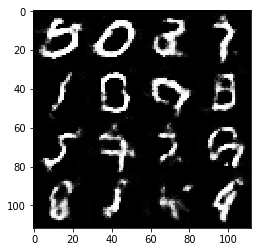

Epoch 0/2 Batch Step 1610... Discriminator Loss: 1.0310... Generator Loss: 1.0543
Epoch 0/2 Batch Step 1620... Discriminator Loss: 1.0795... Generator Loss: 0.8988
Epoch 0/2 Batch Step 1630... Discriminator Loss: 1.0468... Generator Loss: 0.9551
Epoch 0/2 Batch Step 1640... Discriminator Loss: 1.2069... Generator Loss: 0.7376
Epoch 0/2 Batch Step 1650... Discriminator Loss: 1.3540... Generator Loss: 0.6063
Epoch 0/2 Batch Step 1660... Discriminator Loss: 1.1879... Generator Loss: 0.8131
Epoch 0/2 Batch Step 1670... Discriminator Loss: 1.3268... Generator Loss: 0.6087
Epoch 0/2 Batch Step 1680... Discriminator Loss: 1.1093... Generator Loss: 0.8961
Epoch 0/2 Batch Step 1690... Discriminator Loss: 1.1719... Generator Loss: 0.8847
Epoch 0/2 Batch Step 1700... Discriminator Loss: 1.2370... Generator Loss: 1.1674


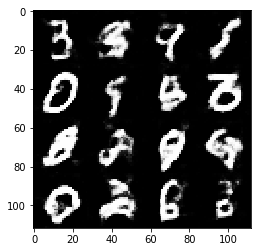

Epoch 0/2 Batch Step 1710... Discriminator Loss: 1.0616... Generator Loss: 1.0096
Epoch 0/2 Batch Step 1720... Discriminator Loss: 1.2388... Generator Loss: 0.8125
Epoch 0/2 Batch Step 1730... Discriminator Loss: 1.2166... Generator Loss: 0.7024
Epoch 0/2 Batch Step 1740... Discriminator Loss: 1.2350... Generator Loss: 0.7232
Epoch 0/2 Batch Step 1750... Discriminator Loss: 1.0943... Generator Loss: 0.9528
Epoch 0/2 Batch Step 1760... Discriminator Loss: 1.2654... Generator Loss: 0.6443
Epoch 0/2 Batch Step 1770... Discriminator Loss: 1.1136... Generator Loss: 0.9027
Epoch 0/2 Batch Step 1780... Discriminator Loss: 1.1583... Generator Loss: 0.8280
Epoch 0/2 Batch Step 1790... Discriminator Loss: 1.1932... Generator Loss: 0.8914
Epoch 0/2 Batch Step 1800... Discriminator Loss: 1.2041... Generator Loss: 0.9137


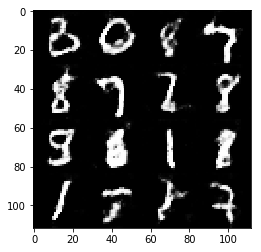

Epoch 0/2 Batch Step 1810... Discriminator Loss: 1.0860... Generator Loss: 0.9661
Epoch 0/2 Batch Step 1820... Discriminator Loss: 1.2137... Generator Loss: 0.7838
Epoch 0/2 Batch Step 1830... Discriminator Loss: 1.2020... Generator Loss: 0.9920
Epoch 0/2 Batch Step 1840... Discriminator Loss: 1.1463... Generator Loss: 0.7187
Epoch 0/2 Batch Step 1850... Discriminator Loss: 1.1701... Generator Loss: 0.7494
Epoch 0/2 Batch Step 1860... Discriminator Loss: 1.1615... Generator Loss: 1.0377
Epoch 0/2 Batch Step 1870... Discriminator Loss: 1.1283... Generator Loss: 0.8382
Epoch 1/2 Batch Step 1880... Discriminator Loss: 1.2981... Generator Loss: 0.6291
Epoch 1/2 Batch Step 1890... Discriminator Loss: 1.3972... Generator Loss: 1.1054
Epoch 1/2 Batch Step 1900... Discriminator Loss: 1.1543... Generator Loss: 1.0699


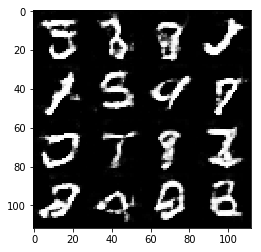

Epoch 1/2 Batch Step 1910... Discriminator Loss: 1.1471... Generator Loss: 0.8734
Epoch 1/2 Batch Step 1920... Discriminator Loss: 1.1969... Generator Loss: 0.8534
Epoch 1/2 Batch Step 1930... Discriminator Loss: 1.1720... Generator Loss: 0.7187
Epoch 1/2 Batch Step 1940... Discriminator Loss: 1.0904... Generator Loss: 0.9291
Epoch 1/2 Batch Step 1950... Discriminator Loss: 1.1894... Generator Loss: 1.1695
Epoch 1/2 Batch Step 1960... Discriminator Loss: 1.0752... Generator Loss: 0.9138
Epoch 1/2 Batch Step 1970... Discriminator Loss: 1.3486... Generator Loss: 0.6167
Epoch 1/2 Batch Step 1980... Discriminator Loss: 1.2857... Generator Loss: 0.6678
Epoch 1/2 Batch Step 1990... Discriminator Loss: 1.2791... Generator Loss: 0.8026
Epoch 1/2 Batch Step 2000... Discriminator Loss: 1.2519... Generator Loss: 0.6270


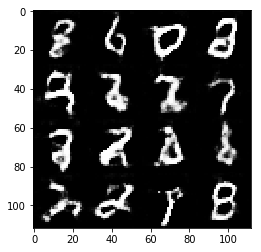

Epoch 1/2 Batch Step 2010... Discriminator Loss: 1.1976... Generator Loss: 0.6837
Epoch 1/2 Batch Step 2020... Discriminator Loss: 1.1317... Generator Loss: 0.9631
Epoch 1/2 Batch Step 2030... Discriminator Loss: 0.9550... Generator Loss: 1.3301
Epoch 1/2 Batch Step 2040... Discriminator Loss: 1.2048... Generator Loss: 0.9929
Epoch 1/2 Batch Step 2050... Discriminator Loss: 1.3088... Generator Loss: 0.6375
Epoch 1/2 Batch Step 2060... Discriminator Loss: 1.1852... Generator Loss: 0.7705
Epoch 1/2 Batch Step 2070... Discriminator Loss: 1.1957... Generator Loss: 0.8334
Epoch 1/2 Batch Step 2080... Discriminator Loss: 1.2860... Generator Loss: 0.7074
Epoch 1/2 Batch Step 2090... Discriminator Loss: 1.2253... Generator Loss: 0.9505
Epoch 1/2 Batch Step 2100... Discriminator Loss: 1.2388... Generator Loss: 0.7015


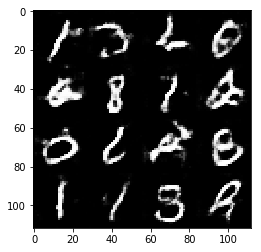

Epoch 1/2 Batch Step 2110... Discriminator Loss: 1.2103... Generator Loss: 0.8428
Epoch 1/2 Batch Step 2120... Discriminator Loss: 1.0600... Generator Loss: 0.9358
Epoch 1/2 Batch Step 2130... Discriminator Loss: 1.1895... Generator Loss: 0.8024
Epoch 1/2 Batch Step 2140... Discriminator Loss: 1.2503... Generator Loss: 0.6013
Epoch 1/2 Batch Step 2150... Discriminator Loss: 1.1703... Generator Loss: 0.8097
Epoch 1/2 Batch Step 2160... Discriminator Loss: 1.2576... Generator Loss: 1.0492
Epoch 1/2 Batch Step 2170... Discriminator Loss: 1.3805... Generator Loss: 0.5442
Epoch 1/2 Batch Step 2180... Discriminator Loss: 1.2877... Generator Loss: 0.7506
Epoch 1/2 Batch Step 2190... Discriminator Loss: 1.2501... Generator Loss: 0.9810
Epoch 1/2 Batch Step 2200... Discriminator Loss: 1.2569... Generator Loss: 0.6731


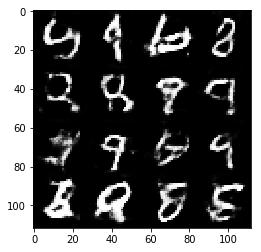

Epoch 1/2 Batch Step 2210... Discriminator Loss: 1.1967... Generator Loss: 1.5342
Epoch 1/2 Batch Step 2220... Discriminator Loss: 1.2476... Generator Loss: 0.8655
Epoch 1/2 Batch Step 2230... Discriminator Loss: 1.1723... Generator Loss: 0.7399
Epoch 1/2 Batch Step 2240... Discriminator Loss: 1.1012... Generator Loss: 0.9135
Epoch 1/2 Batch Step 2250... Discriminator Loss: 1.3149... Generator Loss: 0.9542
Epoch 1/2 Batch Step 2260... Discriminator Loss: 1.2514... Generator Loss: 0.6791
Epoch 1/2 Batch Step 2270... Discriminator Loss: 1.0984... Generator Loss: 0.8681
Epoch 1/2 Batch Step 2280... Discriminator Loss: 1.2289... Generator Loss: 0.7177
Epoch 1/2 Batch Step 2290... Discriminator Loss: 1.1398... Generator Loss: 0.7803
Epoch 1/2 Batch Step 2300... Discriminator Loss: 1.1925... Generator Loss: 0.7362


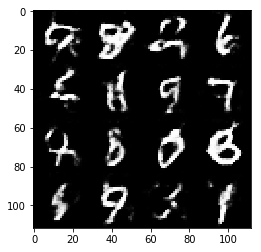

Epoch 1/2 Batch Step 2310... Discriminator Loss: 1.1683... Generator Loss: 0.7754
Epoch 1/2 Batch Step 2320... Discriminator Loss: 1.0778... Generator Loss: 0.9316
Epoch 1/2 Batch Step 2330... Discriminator Loss: 1.0630... Generator Loss: 0.9883
Epoch 1/2 Batch Step 2340... Discriminator Loss: 1.1662... Generator Loss: 0.9299
Epoch 1/2 Batch Step 2350... Discriminator Loss: 1.0641... Generator Loss: 0.9444
Epoch 1/2 Batch Step 2360... Discriminator Loss: 1.1738... Generator Loss: 0.9018
Epoch 1/2 Batch Step 2370... Discriminator Loss: 1.1277... Generator Loss: 1.0081
Epoch 1/2 Batch Step 2380... Discriminator Loss: 1.1307... Generator Loss: 0.9473
Epoch 1/2 Batch Step 2390... Discriminator Loss: 1.2912... Generator Loss: 0.6352
Epoch 1/2 Batch Step 2400... Discriminator Loss: 1.4506... Generator Loss: 0.4950


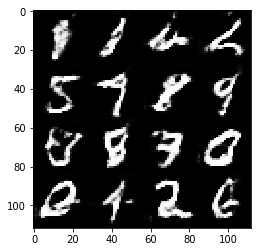

Epoch 1/2 Batch Step 2410... Discriminator Loss: 1.1254... Generator Loss: 0.7876
Epoch 1/2 Batch Step 2420... Discriminator Loss: 1.0890... Generator Loss: 1.0000
Epoch 1/2 Batch Step 2430... Discriminator Loss: 1.2247... Generator Loss: 0.6685
Epoch 1/2 Batch Step 2440... Discriminator Loss: 1.1513... Generator Loss: 0.7578
Epoch 1/2 Batch Step 2450... Discriminator Loss: 1.1752... Generator Loss: 0.7543
Epoch 1/2 Batch Step 2460... Discriminator Loss: 1.2007... Generator Loss: 0.7072
Epoch 1/2 Batch Step 2470... Discriminator Loss: 1.0880... Generator Loss: 0.9286
Epoch 1/2 Batch Step 2480... Discriminator Loss: 1.0851... Generator Loss: 1.2951
Epoch 1/2 Batch Step 2490... Discriminator Loss: 1.2539... Generator Loss: 0.5870
Epoch 1/2 Batch Step 2500... Discriminator Loss: 1.3090... Generator Loss: 0.5535


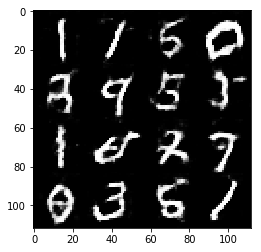

Epoch 1/2 Batch Step 2510... Discriminator Loss: 1.2536... Generator Loss: 0.7158
Epoch 1/2 Batch Step 2520... Discriminator Loss: 1.1572... Generator Loss: 0.8229
Epoch 1/2 Batch Step 2530... Discriminator Loss: 1.2041... Generator Loss: 0.7637
Epoch 1/2 Batch Step 2540... Discriminator Loss: 1.1369... Generator Loss: 0.8334
Epoch 1/2 Batch Step 2550... Discriminator Loss: 1.1584... Generator Loss: 0.7713
Epoch 1/2 Batch Step 2560... Discriminator Loss: 1.2238... Generator Loss: 0.9400
Epoch 1/2 Batch Step 2570... Discriminator Loss: 1.1854... Generator Loss: 1.1672
Epoch 1/2 Batch Step 2580... Discriminator Loss: 1.1604... Generator Loss: 0.7470
Epoch 1/2 Batch Step 2590... Discriminator Loss: 1.1376... Generator Loss: 0.9956
Epoch 1/2 Batch Step 2600... Discriminator Loss: 1.1415... Generator Loss: 0.7832


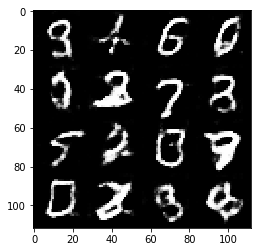

Epoch 1/2 Batch Step 2610... Discriminator Loss: 1.0920... Generator Loss: 0.7836
Epoch 1/2 Batch Step 2620... Discriminator Loss: 1.1256... Generator Loss: 1.1269
Epoch 1/2 Batch Step 2630... Discriminator Loss: 1.1582... Generator Loss: 0.7932
Epoch 1/2 Batch Step 2640... Discriminator Loss: 1.2235... Generator Loss: 1.2559
Epoch 1/2 Batch Step 2650... Discriminator Loss: 1.2243... Generator Loss: 0.7304
Epoch 1/2 Batch Step 2660... Discriminator Loss: 1.1541... Generator Loss: 0.8312
Epoch 1/2 Batch Step 2670... Discriminator Loss: 1.2292... Generator Loss: 0.6757
Epoch 1/2 Batch Step 2680... Discriminator Loss: 1.1930... Generator Loss: 0.6896
Epoch 1/2 Batch Step 2690... Discriminator Loss: 1.1196... Generator Loss: 1.0479
Epoch 1/2 Batch Step 2700... Discriminator Loss: 1.1360... Generator Loss: 1.2433


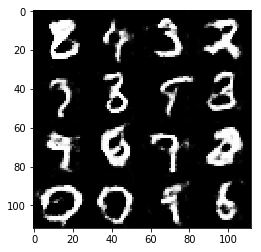

Epoch 1/2 Batch Step 2710... Discriminator Loss: 1.2516... Generator Loss: 0.6708
Epoch 1/2 Batch Step 2720... Discriminator Loss: 1.3158... Generator Loss: 0.6208
Epoch 1/2 Batch Step 2730... Discriminator Loss: 1.2493... Generator Loss: 0.7062
Epoch 1/2 Batch Step 2740... Discriminator Loss: 1.2002... Generator Loss: 0.6996
Epoch 1/2 Batch Step 2750... Discriminator Loss: 1.1814... Generator Loss: 0.7725
Epoch 1/2 Batch Step 2760... Discriminator Loss: 1.1111... Generator Loss: 1.1123
Epoch 1/2 Batch Step 2770... Discriminator Loss: 1.1649... Generator Loss: 0.9669
Epoch 1/2 Batch Step 2780... Discriminator Loss: 1.1765... Generator Loss: 0.7953
Epoch 1/2 Batch Step 2790... Discriminator Loss: 1.2826... Generator Loss: 0.7714
Epoch 1/2 Batch Step 2800... Discriminator Loss: 1.2411... Generator Loss: 1.1545


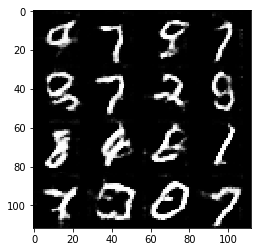

Epoch 1/2 Batch Step 2810... Discriminator Loss: 1.3951... Generator Loss: 0.5125
Epoch 1/2 Batch Step 2820... Discriminator Loss: 1.1248... Generator Loss: 1.1331
Epoch 1/2 Batch Step 2830... Discriminator Loss: 1.1574... Generator Loss: 0.7822
Epoch 1/2 Batch Step 2840... Discriminator Loss: 1.1155... Generator Loss: 1.0741
Epoch 1/2 Batch Step 2850... Discriminator Loss: 1.3804... Generator Loss: 1.3320
Epoch 1/2 Batch Step 2860... Discriminator Loss: 1.1457... Generator Loss: 0.9201
Epoch 1/2 Batch Step 2870... Discriminator Loss: 1.1889... Generator Loss: 0.8090
Epoch 1/2 Batch Step 2880... Discriminator Loss: 1.0481... Generator Loss: 0.9708
Epoch 1/2 Batch Step 2890... Discriminator Loss: 1.0096... Generator Loss: 0.9822
Epoch 1/2 Batch Step 2900... Discriminator Loss: 1.1802... Generator Loss: 0.9575


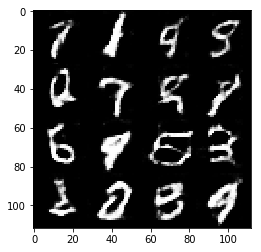

Epoch 1/2 Batch Step 2910... Discriminator Loss: 1.1346... Generator Loss: 1.1104
Epoch 1/2 Batch Step 2920... Discriminator Loss: 1.1079... Generator Loss: 1.1763
Epoch 1/2 Batch Step 2930... Discriminator Loss: 1.2058... Generator Loss: 0.6286
Epoch 1/2 Batch Step 2940... Discriminator Loss: 1.3910... Generator Loss: 0.4984
Epoch 1/2 Batch Step 2950... Discriminator Loss: 1.2077... Generator Loss: 0.8302
Epoch 1/2 Batch Step 2960... Discriminator Loss: 1.1845... Generator Loss: 0.7870
Epoch 1/2 Batch Step 2970... Discriminator Loss: 1.1317... Generator Loss: 0.8424
Epoch 1/2 Batch Step 2980... Discriminator Loss: 1.2819... Generator Loss: 0.8166
Epoch 1/2 Batch Step 2990... Discriminator Loss: 1.2233... Generator Loss: 0.6291
Epoch 1/2 Batch Step 3000... Discriminator Loss: 1.1409... Generator Loss: 0.8009


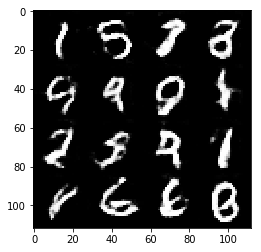

Epoch 1/2 Batch Step 3010... Discriminator Loss: 1.0622... Generator Loss: 1.1398
Epoch 1/2 Batch Step 3020... Discriminator Loss: 1.2013... Generator Loss: 0.6754
Epoch 1/2 Batch Step 3030... Discriminator Loss: 1.3685... Generator Loss: 0.5179
Epoch 1/2 Batch Step 3040... Discriminator Loss: 1.2980... Generator Loss: 0.8923
Epoch 1/2 Batch Step 3050... Discriminator Loss: 1.2607... Generator Loss: 0.6949
Epoch 1/2 Batch Step 3060... Discriminator Loss: 1.0032... Generator Loss: 1.2957
Epoch 1/2 Batch Step 3070... Discriminator Loss: 1.3820... Generator Loss: 0.5048
Epoch 1/2 Batch Step 3080... Discriminator Loss: 1.0238... Generator Loss: 1.1999
Epoch 1/2 Batch Step 3090... Discriminator Loss: 1.1394... Generator Loss: 0.9361
Epoch 1/2 Batch Step 3100... Discriminator Loss: 1.1364... Generator Loss: 0.8236


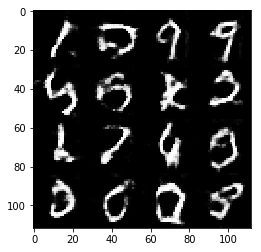

Epoch 1/2 Batch Step 3110... Discriminator Loss: 1.1952... Generator Loss: 0.8329
Epoch 1/2 Batch Step 3120... Discriminator Loss: 1.4626... Generator Loss: 0.4716
Epoch 1/2 Batch Step 3130... Discriminator Loss: 1.2062... Generator Loss: 0.9733
Epoch 1/2 Batch Step 3140... Discriminator Loss: 1.2117... Generator Loss: 0.7906
Epoch 1/2 Batch Step 3150... Discriminator Loss: 1.4677... Generator Loss: 0.4630
Epoch 1/2 Batch Step 3160... Discriminator Loss: 1.1542... Generator Loss: 0.7927
Epoch 1/2 Batch Step 3170... Discriminator Loss: 1.2228... Generator Loss: 0.7304
Epoch 1/2 Batch Step 3180... Discriminator Loss: 1.0451... Generator Loss: 0.8264
Epoch 1/2 Batch Step 3190... Discriminator Loss: 1.2205... Generator Loss: 0.6679
Epoch 1/2 Batch Step 3200... Discriminator Loss: 1.3210... Generator Loss: 0.5784


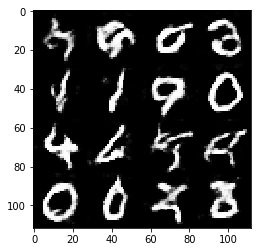

Epoch 1/2 Batch Step 3210... Discriminator Loss: 1.3131... Generator Loss: 0.7569
Epoch 1/2 Batch Step 3220... Discriminator Loss: 1.2185... Generator Loss: 0.7846
Epoch 1/2 Batch Step 3230... Discriminator Loss: 1.1615... Generator Loss: 0.8175
Epoch 1/2 Batch Step 3240... Discriminator Loss: 1.2532... Generator Loss: 0.6227
Epoch 1/2 Batch Step 3250... Discriminator Loss: 1.2143... Generator Loss: 0.7133
Epoch 1/2 Batch Step 3260... Discriminator Loss: 1.0667... Generator Loss: 0.8920
Epoch 1/2 Batch Step 3270... Discriminator Loss: 1.1976... Generator Loss: 0.8042
Epoch 1/2 Batch Step 3280... Discriminator Loss: 1.0584... Generator Loss: 1.0079
Epoch 1/2 Batch Step 3290... Discriminator Loss: 1.0958... Generator Loss: 0.8206
Epoch 1/2 Batch Step 3300... Discriminator Loss: 1.0894... Generator Loss: 1.1893


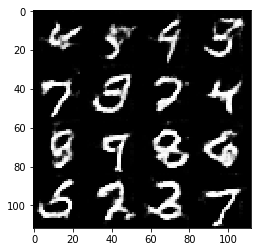

Epoch 1/2 Batch Step 3310... Discriminator Loss: 1.1420... Generator Loss: 1.1223
Epoch 1/2 Batch Step 3320... Discriminator Loss: 1.1222... Generator Loss: 0.9694
Epoch 1/2 Batch Step 3330... Discriminator Loss: 1.3143... Generator Loss: 0.5764
Epoch 1/2 Batch Step 3340... Discriminator Loss: 1.1363... Generator Loss: 0.8228
Epoch 1/2 Batch Step 3350... Discriminator Loss: 1.0540... Generator Loss: 1.2361
Epoch 1/2 Batch Step 3360... Discriminator Loss: 1.0921... Generator Loss: 0.8275
Epoch 1/2 Batch Step 3370... Discriminator Loss: 1.1780... Generator Loss: 0.7726
Epoch 1/2 Batch Step 3380... Discriminator Loss: 1.1839... Generator Loss: 0.7249
Epoch 1/2 Batch Step 3390... Discriminator Loss: 1.1149... Generator Loss: 0.8054
Epoch 1/2 Batch Step 3400... Discriminator Loss: 1.1257... Generator Loss: 0.7834


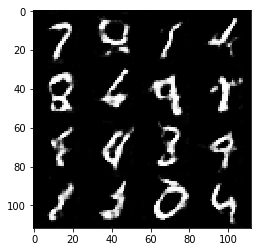

Epoch 1/2 Batch Step 3410... Discriminator Loss: 1.1870... Generator Loss: 0.6822
Epoch 1/2 Batch Step 3420... Discriminator Loss: 1.0104... Generator Loss: 1.0591
Epoch 1/2 Batch Step 3430... Discriminator Loss: 0.9653... Generator Loss: 0.9630
Epoch 1/2 Batch Step 3440... Discriminator Loss: 1.1220... Generator Loss: 0.7304
Epoch 1/2 Batch Step 3450... Discriminator Loss: 1.3472... Generator Loss: 0.5230
Epoch 1/2 Batch Step 3460... Discriminator Loss: 0.9996... Generator Loss: 1.3359
Epoch 1/2 Batch Step 3470... Discriminator Loss: 1.2970... Generator Loss: 0.5841
Epoch 1/2 Batch Step 3480... Discriminator Loss: 0.9618... Generator Loss: 0.9439
Epoch 1/2 Batch Step 3490... Discriminator Loss: 0.9365... Generator Loss: 1.0590
Epoch 1/2 Batch Step 3500... Discriminator Loss: 1.3136... Generator Loss: 0.5760


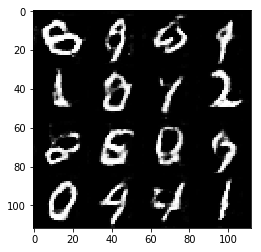

Epoch 1/2 Batch Step 3510... Discriminator Loss: 1.1118... Generator Loss: 0.8670
Epoch 1/2 Batch Step 3520... Discriminator Loss: 1.1306... Generator Loss: 0.8572
Epoch 1/2 Batch Step 3530... Discriminator Loss: 1.3458... Generator Loss: 0.6727
Epoch 1/2 Batch Step 3540... Discriminator Loss: 1.1939... Generator Loss: 0.6637
Epoch 1/2 Batch Step 3550... Discriminator Loss: 1.1518... Generator Loss: 0.7599
Epoch 1/2 Batch Step 3560... Discriminator Loss: 1.1554... Generator Loss: 0.8583
Epoch 1/2 Batch Step 3570... Discriminator Loss: 1.0665... Generator Loss: 0.9922
Epoch 1/2 Batch Step 3580... Discriminator Loss: 1.0594... Generator Loss: 1.1569
Epoch 1/2 Batch Step 3590... Discriminator Loss: 1.2913... Generator Loss: 0.6185
Epoch 1/2 Batch Step 3600... Discriminator Loss: 0.9647... Generator Loss: 1.0013


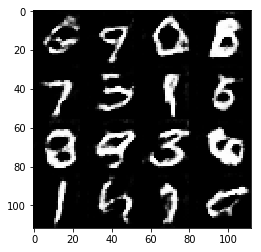

Epoch 1/2 Batch Step 3610... Discriminator Loss: 1.2172... Generator Loss: 0.6070
Epoch 1/2 Batch Step 3620... Discriminator Loss: 1.1333... Generator Loss: 0.7118
Epoch 1/2 Batch Step 3630... Discriminator Loss: 1.2006... Generator Loss: 1.6703
Epoch 1/2 Batch Step 3640... Discriminator Loss: 1.4684... Generator Loss: 0.4658
Epoch 1/2 Batch Step 3650... Discriminator Loss: 1.1744... Generator Loss: 0.8615
Epoch 1/2 Batch Step 3660... Discriminator Loss: 1.2859... Generator Loss: 0.6769
Epoch 1/2 Batch Step 3670... Discriminator Loss: 1.1727... Generator Loss: 0.7999
Epoch 1/2 Batch Step 3680... Discriminator Loss: 1.5311... Generator Loss: 0.3899
Epoch 1/2 Batch Step 3690... Discriminator Loss: 1.1240... Generator Loss: 1.4415
Epoch 1/2 Batch Step 3700... Discriminator Loss: 1.0339... Generator Loss: 1.1330


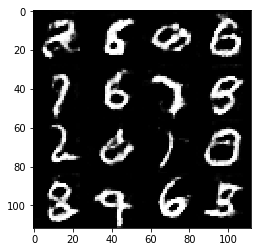

Epoch 1/2 Batch Step 3710... Discriminator Loss: 0.9185... Generator Loss: 1.0639
Epoch 1/2 Batch Step 3720... Discriminator Loss: 1.1325... Generator Loss: 0.8771
Epoch 1/2 Batch Step 3730... Discriminator Loss: 1.1423... Generator Loss: 0.7727
Epoch 1/2 Batch Step 3740... Discriminator Loss: 1.1807... Generator Loss: 0.6496
Epoch 1/2 Batch Step 3750... Discriminator Loss: 1.1086... Generator Loss: 0.9350
Done Training!


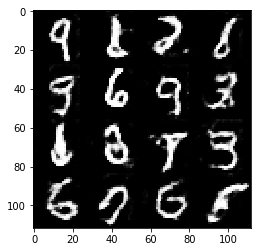

In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.00004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1 Batch Step 10... Discriminator Loss: 4.0045... Generator Loss: 0.0558
Epoch 0/1 Batch Step 20... Discriminator Loss: 3.0266... Generator Loss: 0.1644
Epoch 0/1 Batch Step 30... Discriminator Loss: 2.0334... Generator Loss: 0.4820
Epoch 0/1 Batch Step 40... Discriminator Loss: 1.4101... Generator Loss: 0.9145
Epoch 0/1 Batch Step 50... Discriminator Loss: 1.3584... Generator Loss: 0.7981
Epoch 0/1 Batch Step 60... Discriminator Loss: 1.4771... Generator Loss: 0.6837
Epoch 0/1 Batch Step 70... Discriminator Loss: 1.1084... Generator Loss: 1.2072
Epoch 0/1 Batch Step 80... Discriminator Loss: 0.9207... Generator Loss: 1.7667
Epoch 0/1 Batch Step 90... Discriminator Loss: 1.1482... Generator Loss: 1.8718
Epoch 0/1 Batch Step 100... Discriminator Loss: 1.0844... Generator Loss: 0.9223


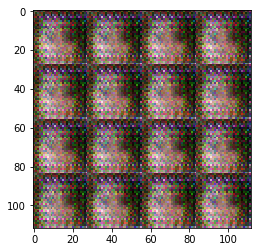

Epoch 0/1 Batch Step 110... Discriminator Loss: 0.8774... Generator Loss: 1.4962
Epoch 0/1 Batch Step 120... Discriminator Loss: 0.7474... Generator Loss: 1.9542
Epoch 0/1 Batch Step 130... Discriminator Loss: 0.8064... Generator Loss: 1.5459
Epoch 0/1 Batch Step 140... Discriminator Loss: 0.6471... Generator Loss: 1.7554
Epoch 0/1 Batch Step 150... Discriminator Loss: 0.6966... Generator Loss: 1.8812
Epoch 0/1 Batch Step 160... Discriminator Loss: 0.8496... Generator Loss: 1.6953
Epoch 0/1 Batch Step 170... Discriminator Loss: 0.9240... Generator Loss: 1.1539
Epoch 0/1 Batch Step 180... Discriminator Loss: 0.6729... Generator Loss: 2.0941
Epoch 0/1 Batch Step 190... Discriminator Loss: 0.8853... Generator Loss: 1.2228
Epoch 0/1 Batch Step 200... Discriminator Loss: 0.5509... Generator Loss: 2.2897


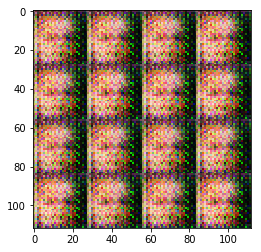

Epoch 0/1 Batch Step 210... Discriminator Loss: 0.6243... Generator Loss: 1.8703
Epoch 0/1 Batch Step 220... Discriminator Loss: 0.5413... Generator Loss: 2.2362
Epoch 0/1 Batch Step 230... Discriminator Loss: 0.5025... Generator Loss: 2.3962
Epoch 0/1 Batch Step 240... Discriminator Loss: 0.5575... Generator Loss: 2.2484
Epoch 0/1 Batch Step 250... Discriminator Loss: 0.5831... Generator Loss: 2.6021
Epoch 0/1 Batch Step 260... Discriminator Loss: 0.5011... Generator Loss: 2.6953
Epoch 0/1 Batch Step 270... Discriminator Loss: 0.5103... Generator Loss: 2.5542
Epoch 0/1 Batch Step 280... Discriminator Loss: 0.4773... Generator Loss: 2.7044
Epoch 0/1 Batch Step 290... Discriminator Loss: 0.4874... Generator Loss: 2.7416
Epoch 0/1 Batch Step 300... Discriminator Loss: 0.4318... Generator Loss: 3.0806


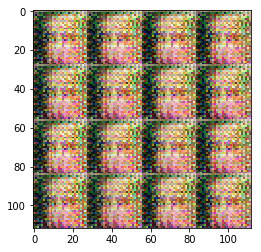

Epoch 0/1 Batch Step 310... Discriminator Loss: 0.4985... Generator Loss: 2.3740
Epoch 0/1 Batch Step 320... Discriminator Loss: 0.6080... Generator Loss: 1.9681
Epoch 0/1 Batch Step 330... Discriminator Loss: 1.3665... Generator Loss: 0.7468
Epoch 0/1 Batch Step 340... Discriminator Loss: 1.3957... Generator Loss: 1.0030
Epoch 0/1 Batch Step 350... Discriminator Loss: 1.2122... Generator Loss: 0.7456
Epoch 0/1 Batch Step 360... Discriminator Loss: 1.2646... Generator Loss: 0.7864
Epoch 0/1 Batch Step 370... Discriminator Loss: 1.3291... Generator Loss: 0.7464
Epoch 0/1 Batch Step 380... Discriminator Loss: 1.4781... Generator Loss: 0.6781
Epoch 0/1 Batch Step 390... Discriminator Loss: 1.0637... Generator Loss: 1.1112
Epoch 0/1 Batch Step 400... Discriminator Loss: 1.0402... Generator Loss: 1.1593


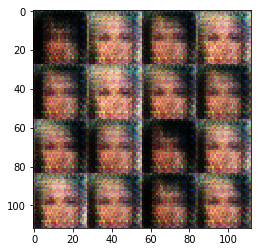

Epoch 0/1 Batch Step 410... Discriminator Loss: 0.9817... Generator Loss: 1.0913
Epoch 0/1 Batch Step 420... Discriminator Loss: 1.1944... Generator Loss: 0.8838
Epoch 0/1 Batch Step 430... Discriminator Loss: 1.4519... Generator Loss: 0.7383
Epoch 0/1 Batch Step 440... Discriminator Loss: 1.7757... Generator Loss: 0.5425
Epoch 0/1 Batch Step 450... Discriminator Loss: 1.4756... Generator Loss: 0.8940
Epoch 0/1 Batch Step 460... Discriminator Loss: 1.5594... Generator Loss: 0.6928
Epoch 0/1 Batch Step 470... Discriminator Loss: 1.4818... Generator Loss: 0.7245
Epoch 0/1 Batch Step 480... Discriminator Loss: 1.2839... Generator Loss: 0.7856
Epoch 0/1 Batch Step 490... Discriminator Loss: 1.7054... Generator Loss: 0.7880
Epoch 0/1 Batch Step 500... Discriminator Loss: 1.6899... Generator Loss: 0.5970


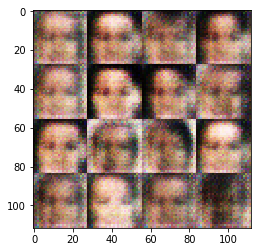

Epoch 0/1 Batch Step 510... Discriminator Loss: 1.4280... Generator Loss: 0.8074
Epoch 0/1 Batch Step 520... Discriminator Loss: 1.4200... Generator Loss: 0.8590
Epoch 0/1 Batch Step 530... Discriminator Loss: 1.4565... Generator Loss: 0.7017
Epoch 0/1 Batch Step 540... Discriminator Loss: 1.5256... Generator Loss: 0.7051
Epoch 0/1 Batch Step 550... Discriminator Loss: 1.4706... Generator Loss: 0.6995
Epoch 0/1 Batch Step 560... Discriminator Loss: 1.4790... Generator Loss: 0.7380
Epoch 0/1 Batch Step 570... Discriminator Loss: 1.4767... Generator Loss: 0.8266
Epoch 0/1 Batch Step 580... Discriminator Loss: 1.4130... Generator Loss: 0.6896
Epoch 0/1 Batch Step 590... Discriminator Loss: 1.4342... Generator Loss: 0.7356
Epoch 0/1 Batch Step 600... Discriminator Loss: 1.4862... Generator Loss: 0.7455


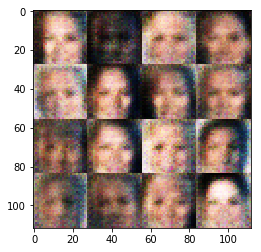

Epoch 0/1 Batch Step 610... Discriminator Loss: 1.3972... Generator Loss: 0.7923
Epoch 0/1 Batch Step 620... Discriminator Loss: 1.3924... Generator Loss: 0.7758
Epoch 0/1 Batch Step 630... Discriminator Loss: 1.5012... Generator Loss: 0.6417
Epoch 0/1 Batch Step 640... Discriminator Loss: 1.3918... Generator Loss: 0.7520
Epoch 0/1 Batch Step 650... Discriminator Loss: 1.4329... Generator Loss: 0.7221
Epoch 0/1 Batch Step 660... Discriminator Loss: 1.4721... Generator Loss: 0.6217
Epoch 0/1 Batch Step 670... Discriminator Loss: 1.5059... Generator Loss: 0.6314
Epoch 0/1 Batch Step 680... Discriminator Loss: 1.4523... Generator Loss: 0.6994
Epoch 0/1 Batch Step 690... Discriminator Loss: 1.3883... Generator Loss: 0.7544
Epoch 0/1 Batch Step 700... Discriminator Loss: 1.3856... Generator Loss: 0.7928


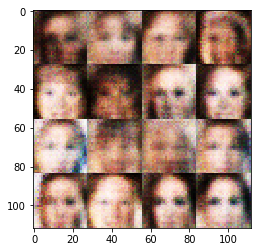

Epoch 0/1 Batch Step 710... Discriminator Loss: 1.4236... Generator Loss: 0.7227
Epoch 0/1 Batch Step 720... Discriminator Loss: 1.4197... Generator Loss: 0.7463
Epoch 0/1 Batch Step 730... Discriminator Loss: 1.3749... Generator Loss: 0.7486
Epoch 0/1 Batch Step 740... Discriminator Loss: 1.4434... Generator Loss: 0.7652
Epoch 0/1 Batch Step 750... Discriminator Loss: 1.3841... Generator Loss: 0.7974
Epoch 0/1 Batch Step 760... Discriminator Loss: 1.3569... Generator Loss: 0.7180
Epoch 0/1 Batch Step 770... Discriminator Loss: 1.4011... Generator Loss: 0.8599
Epoch 0/1 Batch Step 780... Discriminator Loss: 1.3945... Generator Loss: 0.8042
Epoch 0/1 Batch Step 790... Discriminator Loss: 1.4092... Generator Loss: 0.7679
Epoch 0/1 Batch Step 800... Discriminator Loss: 1.3975... Generator Loss: 0.7805


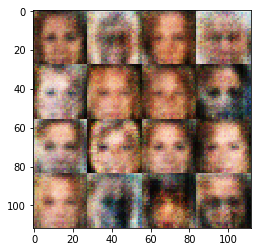

Epoch 0/1 Batch Step 810... Discriminator Loss: 1.4665... Generator Loss: 0.6757
Epoch 0/1 Batch Step 820... Discriminator Loss: 1.3657... Generator Loss: 0.8961
Epoch 0/1 Batch Step 830... Discriminator Loss: 1.4248... Generator Loss: 0.7173
Epoch 0/1 Batch Step 840... Discriminator Loss: 1.4218... Generator Loss: 0.6440
Epoch 0/1 Batch Step 850... Discriminator Loss: 1.3988... Generator Loss: 0.8235
Epoch 0/1 Batch Step 860... Discriminator Loss: 1.4019... Generator Loss: 0.7363
Epoch 0/1 Batch Step 870... Discriminator Loss: 1.4341... Generator Loss: 0.7477
Epoch 0/1 Batch Step 880... Discriminator Loss: 1.5153... Generator Loss: 0.7201
Epoch 0/1 Batch Step 890... Discriminator Loss: 1.4316... Generator Loss: 0.8026
Epoch 0/1 Batch Step 900... Discriminator Loss: 1.4467... Generator Loss: 0.7404


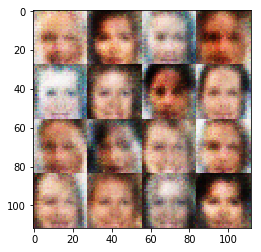

Epoch 0/1 Batch Step 910... Discriminator Loss: 1.4101... Generator Loss: 0.7986
Epoch 0/1 Batch Step 920... Discriminator Loss: 1.4895... Generator Loss: 0.6891
Epoch 0/1 Batch Step 930... Discriminator Loss: 1.4176... Generator Loss: 0.7949
Epoch 0/1 Batch Step 940... Discriminator Loss: 1.3989... Generator Loss: 0.7531
Epoch 0/1 Batch Step 950... Discriminator Loss: 1.4495... Generator Loss: 0.6594
Epoch 0/1 Batch Step 960... Discriminator Loss: 1.4312... Generator Loss: 0.7770
Epoch 0/1 Batch Step 970... Discriminator Loss: 1.4687... Generator Loss: 0.6482
Epoch 0/1 Batch Step 980... Discriminator Loss: 1.4548... Generator Loss: 0.7570
Epoch 0/1 Batch Step 990... Discriminator Loss: 1.3952... Generator Loss: 0.7342
Epoch 0/1 Batch Step 1000... Discriminator Loss: 1.4460... Generator Loss: 0.6866


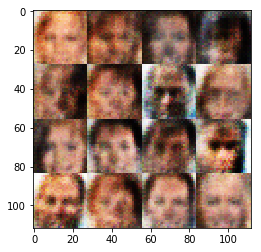

Epoch 0/1 Batch Step 1010... Discriminator Loss: 1.4609... Generator Loss: 0.7562
Epoch 0/1 Batch Step 1020... Discriminator Loss: 1.4897... Generator Loss: 0.8312
Epoch 0/1 Batch Step 1030... Discriminator Loss: 1.4556... Generator Loss: 0.6831
Epoch 0/1 Batch Step 1040... Discriminator Loss: 1.4164... Generator Loss: 0.7136
Epoch 0/1 Batch Step 1050... Discriminator Loss: 1.4386... Generator Loss: 0.7046
Epoch 0/1 Batch Step 1060... Discriminator Loss: 1.4265... Generator Loss: 0.7701
Epoch 0/1 Batch Step 1070... Discriminator Loss: 1.4542... Generator Loss: 0.8228
Epoch 0/1 Batch Step 1080... Discriminator Loss: 1.5288... Generator Loss: 0.6231
Epoch 0/1 Batch Step 1090... Discriminator Loss: 1.4226... Generator Loss: 0.6812
Epoch 0/1 Batch Step 1100... Discriminator Loss: 1.4818... Generator Loss: 0.7173


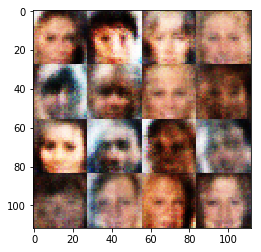

Epoch 0/1 Batch Step 1110... Discriminator Loss: 1.4450... Generator Loss: 0.6992
Epoch 0/1 Batch Step 1120... Discriminator Loss: 1.4488... Generator Loss: 0.7516
Epoch 0/1 Batch Step 1130... Discriminator Loss: 1.4343... Generator Loss: 0.8342
Epoch 0/1 Batch Step 1140... Discriminator Loss: 1.4355... Generator Loss: 0.7785
Epoch 0/1 Batch Step 1150... Discriminator Loss: 1.4581... Generator Loss: 0.7524
Epoch 0/1 Batch Step 1160... Discriminator Loss: 1.4573... Generator Loss: 0.6520
Epoch 0/1 Batch Step 1170... Discriminator Loss: 1.4304... Generator Loss: 0.7067
Epoch 0/1 Batch Step 1180... Discriminator Loss: 1.4794... Generator Loss: 0.6624
Epoch 0/1 Batch Step 1190... Discriminator Loss: 1.4066... Generator Loss: 0.7437
Epoch 0/1 Batch Step 1200... Discriminator Loss: 1.4378... Generator Loss: 0.7764


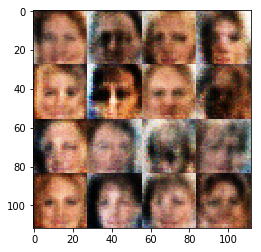

Epoch 0/1 Batch Step 1210... Discriminator Loss: 1.4229... Generator Loss: 0.7213
Epoch 0/1 Batch Step 1220... Discriminator Loss: 1.4283... Generator Loss: 0.6921
Epoch 0/1 Batch Step 1230... Discriminator Loss: 1.4218... Generator Loss: 0.7304
Epoch 0/1 Batch Step 1240... Discriminator Loss: 1.4234... Generator Loss: 0.6734
Epoch 0/1 Batch Step 1250... Discriminator Loss: 1.4394... Generator Loss: 0.7648
Epoch 0/1 Batch Step 1260... Discriminator Loss: 1.4651... Generator Loss: 0.6363
Epoch 0/1 Batch Step 1270... Discriminator Loss: 1.4526... Generator Loss: 0.7116
Epoch 0/1 Batch Step 1280... Discriminator Loss: 1.4337... Generator Loss: 0.8316
Epoch 0/1 Batch Step 1290... Discriminator Loss: 1.4289... Generator Loss: 0.7228
Epoch 0/1 Batch Step 1300... Discriminator Loss: 1.4061... Generator Loss: 0.7217


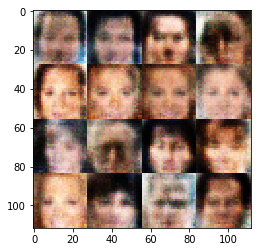

Epoch 0/1 Batch Step 1310... Discriminator Loss: 1.4703... Generator Loss: 0.7036
Epoch 0/1 Batch Step 1320... Discriminator Loss: 1.4311... Generator Loss: 0.7208
Epoch 0/1 Batch Step 1330... Discriminator Loss: 1.4307... Generator Loss: 0.6702
Epoch 0/1 Batch Step 1340... Discriminator Loss: 1.4346... Generator Loss: 0.7117
Epoch 0/1 Batch Step 1350... Discriminator Loss: 1.4480... Generator Loss: 0.7775
Epoch 0/1 Batch Step 1360... Discriminator Loss: 1.4342... Generator Loss: 0.8001
Epoch 0/1 Batch Step 1370... Discriminator Loss: 1.4110... Generator Loss: 0.7557
Epoch 0/1 Batch Step 1380... Discriminator Loss: 1.4302... Generator Loss: 0.8330
Epoch 0/1 Batch Step 1390... Discriminator Loss: 1.4751... Generator Loss: 0.7022
Epoch 0/1 Batch Step 1400... Discriminator Loss: 1.4465... Generator Loss: 0.7106


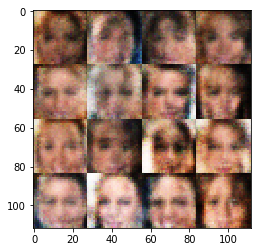

Epoch 0/1 Batch Step 1410... Discriminator Loss: 1.4435... Generator Loss: 0.7520
Epoch 0/1 Batch Step 1420... Discriminator Loss: 1.3838... Generator Loss: 0.7801
Epoch 0/1 Batch Step 1430... Discriminator Loss: 1.3985... Generator Loss: 0.7400
Epoch 0/1 Batch Step 1440... Discriminator Loss: 1.4225... Generator Loss: 0.7540
Epoch 0/1 Batch Step 1450... Discriminator Loss: 1.4488... Generator Loss: 0.7133
Epoch 0/1 Batch Step 1460... Discriminator Loss: 1.4647... Generator Loss: 0.7897
Epoch 0/1 Batch Step 1470... Discriminator Loss: 1.4562... Generator Loss: 0.6867
Epoch 0/1 Batch Step 1480... Discriminator Loss: 1.4065... Generator Loss: 0.7213
Epoch 0/1 Batch Step 1490... Discriminator Loss: 1.4158... Generator Loss: 0.7987
Epoch 0/1 Batch Step 1500... Discriminator Loss: 1.4127... Generator Loss: 0.7155


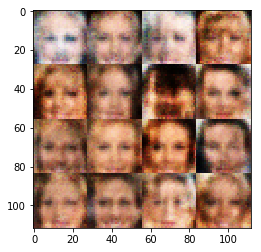

Epoch 0/1 Batch Step 1510... Discriminator Loss: 1.4182... Generator Loss: 0.7754
Epoch 0/1 Batch Step 1520... Discriminator Loss: 1.4089... Generator Loss: 0.7516
Epoch 0/1 Batch Step 1530... Discriminator Loss: 1.4446... Generator Loss: 0.6689
Epoch 0/1 Batch Step 1540... Discriminator Loss: 1.4161... Generator Loss: 0.7085
Epoch 0/1 Batch Step 1550... Discriminator Loss: 1.4042... Generator Loss: 0.7679
Epoch 0/1 Batch Step 1560... Discriminator Loss: 1.4209... Generator Loss: 0.7499
Epoch 0/1 Batch Step 1570... Discriminator Loss: 1.4128... Generator Loss: 0.7476
Epoch 0/1 Batch Step 1580... Discriminator Loss: 1.3885... Generator Loss: 0.8474
Epoch 0/1 Batch Step 1590... Discriminator Loss: 1.3942... Generator Loss: 0.7412
Epoch 0/1 Batch Step 1600... Discriminator Loss: 1.3950... Generator Loss: 0.7276


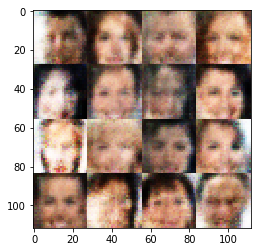

Epoch 0/1 Batch Step 1610... Discriminator Loss: 1.4024... Generator Loss: 0.7960
Epoch 0/1 Batch Step 1620... Discriminator Loss: 1.4590... Generator Loss: 0.7635
Epoch 0/1 Batch Step 1630... Discriminator Loss: 1.4294... Generator Loss: 0.7922
Epoch 0/1 Batch Step 1640... Discriminator Loss: 1.4346... Generator Loss: 0.7212
Epoch 0/1 Batch Step 1650... Discriminator Loss: 1.4204... Generator Loss: 0.8531
Epoch 0/1 Batch Step 1660... Discriminator Loss: 1.4225... Generator Loss: 0.7266
Epoch 0/1 Batch Step 1670... Discriminator Loss: 1.4035... Generator Loss: 0.7906
Epoch 0/1 Batch Step 1680... Discriminator Loss: 1.3622... Generator Loss: 0.8239
Epoch 0/1 Batch Step 1690... Discriminator Loss: 1.4161... Generator Loss: 0.7896
Epoch 0/1 Batch Step 1700... Discriminator Loss: 1.4254... Generator Loss: 0.7849


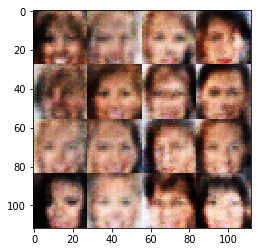

Epoch 0/1 Batch Step 1710... Discriminator Loss: 1.4407... Generator Loss: 0.8163
Epoch 0/1 Batch Step 1720... Discriminator Loss: 1.4197... Generator Loss: 0.7594
Epoch 0/1 Batch Step 1730... Discriminator Loss: 1.4183... Generator Loss: 0.8574
Epoch 0/1 Batch Step 1740... Discriminator Loss: 1.4581... Generator Loss: 0.7985
Epoch 0/1 Batch Step 1750... Discriminator Loss: 1.4202... Generator Loss: 0.7773
Epoch 0/1 Batch Step 1760... Discriminator Loss: 1.4268... Generator Loss: 0.7172
Epoch 0/1 Batch Step 1770... Discriminator Loss: 1.4713... Generator Loss: 0.7713
Epoch 0/1 Batch Step 1780... Discriminator Loss: 1.4113... Generator Loss: 0.7454
Epoch 0/1 Batch Step 1790... Discriminator Loss: 1.4053... Generator Loss: 0.7399
Epoch 0/1 Batch Step 1800... Discriminator Loss: 1.4193... Generator Loss: 0.7168


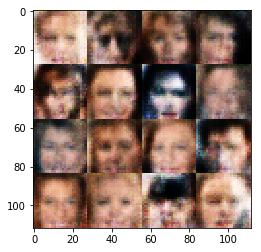

Epoch 0/1 Batch Step 1810... Discriminator Loss: 1.4274... Generator Loss: 0.7557
Epoch 0/1 Batch Step 1820... Discriminator Loss: 1.4212... Generator Loss: 0.7295
Epoch 0/1 Batch Step 1830... Discriminator Loss: 1.4124... Generator Loss: 0.7893
Epoch 0/1 Batch Step 1840... Discriminator Loss: 1.4290... Generator Loss: 0.7829
Epoch 0/1 Batch Step 1850... Discriminator Loss: 1.4250... Generator Loss: 0.6957
Epoch 0/1 Batch Step 1860... Discriminator Loss: 1.4113... Generator Loss: 0.7858
Epoch 0/1 Batch Step 1870... Discriminator Loss: 1.4258... Generator Loss: 0.6960
Epoch 0/1 Batch Step 1880... Discriminator Loss: 1.3800... Generator Loss: 0.7792
Epoch 0/1 Batch Step 1890... Discriminator Loss: 1.4121... Generator Loss: 0.7925
Epoch 0/1 Batch Step 1900... Discriminator Loss: 1.4517... Generator Loss: 0.6764


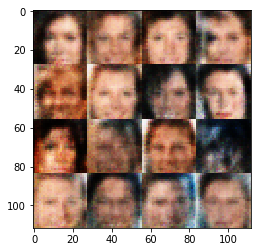

Epoch 0/1 Batch Step 1910... Discriminator Loss: 1.4493... Generator Loss: 0.7309
Epoch 0/1 Batch Step 1920... Discriminator Loss: 1.4628... Generator Loss: 0.7246
Epoch 0/1 Batch Step 1930... Discriminator Loss: 1.4176... Generator Loss: 0.7347
Epoch 0/1 Batch Step 1940... Discriminator Loss: 1.4229... Generator Loss: 0.7525
Epoch 0/1 Batch Step 1950... Discriminator Loss: 1.3919... Generator Loss: 0.8081
Epoch 0/1 Batch Step 1960... Discriminator Loss: 1.4478... Generator Loss: 0.8261
Epoch 0/1 Batch Step 1970... Discriminator Loss: 1.4139... Generator Loss: 0.7212
Epoch 0/1 Batch Step 1980... Discriminator Loss: 1.4138... Generator Loss: 0.7433
Epoch 0/1 Batch Step 1990... Discriminator Loss: 1.3875... Generator Loss: 0.8077
Epoch 0/1 Batch Step 2000... Discriminator Loss: 1.3844... Generator Loss: 0.7254


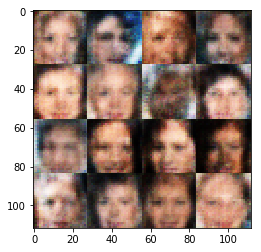

Epoch 0/1 Batch Step 2010... Discriminator Loss: 1.3854... Generator Loss: 0.8709
Epoch 0/1 Batch Step 2020... Discriminator Loss: 1.4207... Generator Loss: 0.7383
Epoch 0/1 Batch Step 2030... Discriminator Loss: 1.3911... Generator Loss: 0.7188
Epoch 0/1 Batch Step 2040... Discriminator Loss: 1.4320... Generator Loss: 0.7791
Epoch 0/1 Batch Step 2050... Discriminator Loss: 1.3943... Generator Loss: 0.7502
Epoch 0/1 Batch Step 2060... Discriminator Loss: 1.4009... Generator Loss: 0.7938
Epoch 0/1 Batch Step 2070... Discriminator Loss: 1.4173... Generator Loss: 0.7205
Epoch 0/1 Batch Step 2080... Discriminator Loss: 1.3944... Generator Loss: 0.7956
Epoch 0/1 Batch Step 2090... Discriminator Loss: 1.4540... Generator Loss: 0.7483
Epoch 0/1 Batch Step 2100... Discriminator Loss: 1.4011... Generator Loss: 0.7249


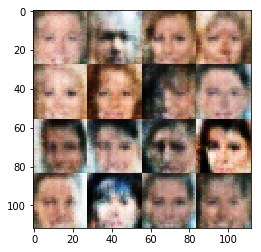

Epoch 0/1 Batch Step 2110... Discriminator Loss: 1.4255... Generator Loss: 0.7384
Epoch 0/1 Batch Step 2120... Discriminator Loss: 1.3881... Generator Loss: 0.7925
Epoch 0/1 Batch Step 2130... Discriminator Loss: 1.4162... Generator Loss: 0.8102
Epoch 0/1 Batch Step 2140... Discriminator Loss: 1.3915... Generator Loss: 0.8059
Epoch 0/1 Batch Step 2150... Discriminator Loss: 1.3751... Generator Loss: 0.8264
Epoch 0/1 Batch Step 2160... Discriminator Loss: 1.4037... Generator Loss: 0.7609
Epoch 0/1 Batch Step 2170... Discriminator Loss: 1.4031... Generator Loss: 0.7258
Epoch 0/1 Batch Step 2180... Discriminator Loss: 1.4056... Generator Loss: 0.7761
Epoch 0/1 Batch Step 2190... Discriminator Loss: 1.4002... Generator Loss: 0.8103
Epoch 0/1 Batch Step 2200... Discriminator Loss: 1.3994... Generator Loss: 0.7199


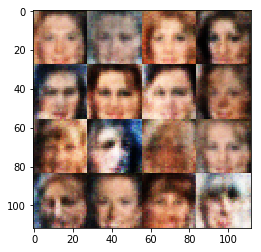

Epoch 0/1 Batch Step 2210... Discriminator Loss: 1.4047... Generator Loss: 0.7555
Epoch 0/1 Batch Step 2220... Discriminator Loss: 1.4102... Generator Loss: 0.7214
Epoch 0/1 Batch Step 2230... Discriminator Loss: 1.4022... Generator Loss: 0.7315
Epoch 0/1 Batch Step 2240... Discriminator Loss: 1.3871... Generator Loss: 0.8065
Epoch 0/1 Batch Step 2250... Discriminator Loss: 1.4280... Generator Loss: 0.7604
Epoch 0/1 Batch Step 2260... Discriminator Loss: 1.4115... Generator Loss: 0.8247
Epoch 0/1 Batch Step 2270... Discriminator Loss: 1.4050... Generator Loss: 0.7708
Epoch 0/1 Batch Step 2280... Discriminator Loss: 1.4051... Generator Loss: 0.7393
Epoch 0/1 Batch Step 2290... Discriminator Loss: 1.4040... Generator Loss: 0.7961
Epoch 0/1 Batch Step 2300... Discriminator Loss: 1.4221... Generator Loss: 0.7784


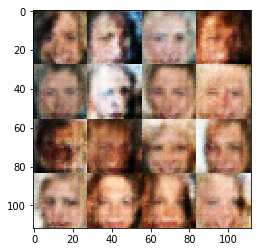

Epoch 0/1 Batch Step 2310... Discriminator Loss: 1.4181... Generator Loss: 0.7999
Epoch 0/1 Batch Step 2320... Discriminator Loss: 1.4047... Generator Loss: 0.7620
Epoch 0/1 Batch Step 2330... Discriminator Loss: 1.4009... Generator Loss: 0.8124
Epoch 0/1 Batch Step 2340... Discriminator Loss: 1.4244... Generator Loss: 0.7898
Epoch 0/1 Batch Step 2350... Discriminator Loss: 1.4230... Generator Loss: 0.7953
Epoch 0/1 Batch Step 2360... Discriminator Loss: 1.3990... Generator Loss: 0.7874
Epoch 0/1 Batch Step 2370... Discriminator Loss: 1.3615... Generator Loss: 0.8257
Epoch 0/1 Batch Step 2380... Discriminator Loss: 1.4079... Generator Loss: 0.7484
Epoch 0/1 Batch Step 2390... Discriminator Loss: 1.3684... Generator Loss: 0.7822
Epoch 0/1 Batch Step 2400... Discriminator Loss: 1.4339... Generator Loss: 0.7703


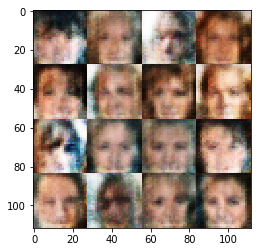

Epoch 0/1 Batch Step 2410... Discriminator Loss: 1.3936... Generator Loss: 0.7985
Epoch 0/1 Batch Step 2420... Discriminator Loss: 1.4033... Generator Loss: 0.7754
Epoch 0/1 Batch Step 2430... Discriminator Loss: 1.4375... Generator Loss: 0.7607
Epoch 0/1 Batch Step 2440... Discriminator Loss: 1.3833... Generator Loss: 0.8034
Epoch 0/1 Batch Step 2450... Discriminator Loss: 1.4423... Generator Loss: 0.7652
Epoch 0/1 Batch Step 2460... Discriminator Loss: 1.3651... Generator Loss: 0.7705
Epoch 0/1 Batch Step 2470... Discriminator Loss: 1.4132... Generator Loss: 0.8200
Epoch 0/1 Batch Step 2480... Discriminator Loss: 1.3853... Generator Loss: 0.7841
Epoch 0/1 Batch Step 2490... Discriminator Loss: 1.3622... Generator Loss: 0.8665
Epoch 0/1 Batch Step 2500... Discriminator Loss: 1.4568... Generator Loss: 0.7425


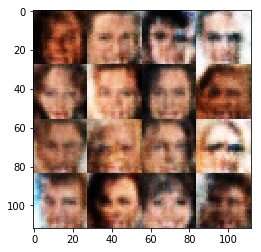

Epoch 0/1 Batch Step 2510... Discriminator Loss: 1.4093... Generator Loss: 0.7352
Epoch 0/1 Batch Step 2520... Discriminator Loss: 1.4074... Generator Loss: 0.7296
Epoch 0/1 Batch Step 2530... Discriminator Loss: 1.4043... Generator Loss: 0.8316
Epoch 0/1 Batch Step 2540... Discriminator Loss: 1.4141... Generator Loss: 0.7340
Epoch 0/1 Batch Step 2550... Discriminator Loss: 1.4063... Generator Loss: 0.8040
Epoch 0/1 Batch Step 2560... Discriminator Loss: 1.3759... Generator Loss: 0.8093
Epoch 0/1 Batch Step 2570... Discriminator Loss: 1.3965... Generator Loss: 0.7418
Epoch 0/1 Batch Step 2580... Discriminator Loss: 1.3983... Generator Loss: 0.8316
Epoch 0/1 Batch Step 2590... Discriminator Loss: 1.4236... Generator Loss: 0.8043
Epoch 0/1 Batch Step 2600... Discriminator Loss: 1.4158... Generator Loss: 0.7238


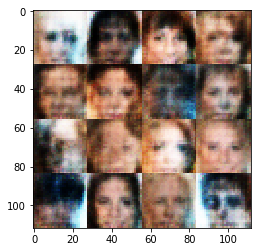

Epoch 0/1 Batch Step 2610... Discriminator Loss: 1.4330... Generator Loss: 0.7691
Epoch 0/1 Batch Step 2620... Discriminator Loss: 1.4497... Generator Loss: 0.7755
Epoch 0/1 Batch Step 2630... Discriminator Loss: 1.3876... Generator Loss: 0.7452
Epoch 0/1 Batch Step 2640... Discriminator Loss: 1.4434... Generator Loss: 0.7366
Epoch 0/1 Batch Step 2650... Discriminator Loss: 1.4317... Generator Loss: 0.7690
Epoch 0/1 Batch Step 2660... Discriminator Loss: 1.3672... Generator Loss: 0.8137
Epoch 0/1 Batch Step 2670... Discriminator Loss: 1.4037... Generator Loss: 0.7960
Epoch 0/1 Batch Step 2680... Discriminator Loss: 1.4417... Generator Loss: 0.7605
Epoch 0/1 Batch Step 2690... Discriminator Loss: 1.4049... Generator Loss: 0.7721
Epoch 0/1 Batch Step 2700... Discriminator Loss: 1.3781... Generator Loss: 0.8000


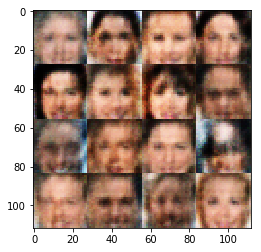

Epoch 0/1 Batch Step 2710... Discriminator Loss: 1.3908... Generator Loss: 0.7824
Epoch 0/1 Batch Step 2720... Discriminator Loss: 1.3999... Generator Loss: 0.8013
Epoch 0/1 Batch Step 2730... Discriminator Loss: 1.4060... Generator Loss: 0.8813
Epoch 0/1 Batch Step 2740... Discriminator Loss: 1.3996... Generator Loss: 0.7684
Epoch 0/1 Batch Step 2750... Discriminator Loss: 1.4106... Generator Loss: 0.7796
Epoch 0/1 Batch Step 2760... Discriminator Loss: 1.4067... Generator Loss: 0.7502
Epoch 0/1 Batch Step 2770... Discriminator Loss: 1.3937... Generator Loss: 0.7413
Epoch 0/1 Batch Step 2780... Discriminator Loss: 1.4459... Generator Loss: 0.8004
Epoch 0/1 Batch Step 2790... Discriminator Loss: 1.3978... Generator Loss: 0.7582
Epoch 0/1 Batch Step 2800... Discriminator Loss: 1.4091... Generator Loss: 0.7988


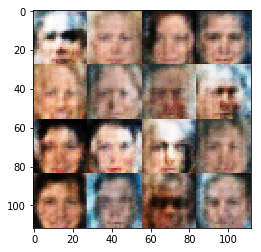

Epoch 0/1 Batch Step 2810... Discriminator Loss: 1.4009... Generator Loss: 0.6996
Epoch 0/1 Batch Step 2820... Discriminator Loss: 1.4139... Generator Loss: 0.8099
Epoch 0/1 Batch Step 2830... Discriminator Loss: 1.3867... Generator Loss: 0.7739
Epoch 0/1 Batch Step 2840... Discriminator Loss: 1.4180... Generator Loss: 0.7812
Epoch 0/1 Batch Step 2850... Discriminator Loss: 1.4030... Generator Loss: 0.7672
Epoch 0/1 Batch Step 2860... Discriminator Loss: 1.3900... Generator Loss: 0.7866
Epoch 0/1 Batch Step 2870... Discriminator Loss: 1.4146... Generator Loss: 0.8087
Epoch 0/1 Batch Step 2880... Discriminator Loss: 1.3909... Generator Loss: 0.7656
Epoch 0/1 Batch Step 2890... Discriminator Loss: 1.3858... Generator Loss: 0.8150
Epoch 0/1 Batch Step 2900... Discriminator Loss: 1.3920... Generator Loss: 0.8645


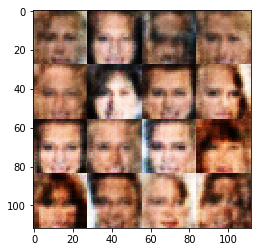

Epoch 0/1 Batch Step 2910... Discriminator Loss: 1.3940... Generator Loss: 0.7641
Epoch 0/1 Batch Step 2920... Discriminator Loss: 1.4049... Generator Loss: 0.7570
Epoch 0/1 Batch Step 2930... Discriminator Loss: 1.4210... Generator Loss: 0.7829
Epoch 0/1 Batch Step 2940... Discriminator Loss: 1.3847... Generator Loss: 0.7718
Epoch 0/1 Batch Step 2950... Discriminator Loss: 1.4116... Generator Loss: 0.7614
Epoch 0/1 Batch Step 2960... Discriminator Loss: 1.4019... Generator Loss: 0.7760
Epoch 0/1 Batch Step 2970... Discriminator Loss: 1.4379... Generator Loss: 0.7645
Epoch 0/1 Batch Step 2980... Discriminator Loss: 1.4341... Generator Loss: 0.7611
Epoch 0/1 Batch Step 2990... Discriminator Loss: 1.4084... Generator Loss: 0.7740
Epoch 0/1 Batch Step 3000... Discriminator Loss: 1.4096... Generator Loss: 0.7554


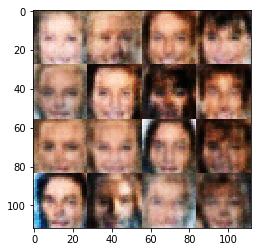

Epoch 0/1 Batch Step 3010... Discriminator Loss: 1.3982... Generator Loss: 0.7440
Epoch 0/1 Batch Step 3020... Discriminator Loss: 1.4048... Generator Loss: 0.7206
Epoch 0/1 Batch Step 3030... Discriminator Loss: 1.4218... Generator Loss: 0.8013
Epoch 0/1 Batch Step 3040... Discriminator Loss: 1.3969... Generator Loss: 0.7043
Epoch 0/1 Batch Step 3050... Discriminator Loss: 1.3939... Generator Loss: 0.7962
Epoch 0/1 Batch Step 3060... Discriminator Loss: 1.4177... Generator Loss: 0.8651
Epoch 0/1 Batch Step 3070... Discriminator Loss: 1.3912... Generator Loss: 0.7736
Epoch 0/1 Batch Step 3080... Discriminator Loss: 1.3880... Generator Loss: 0.7370
Epoch 0/1 Batch Step 3090... Discriminator Loss: 1.3822... Generator Loss: 0.8333
Epoch 0/1 Batch Step 3100... Discriminator Loss: 1.3800... Generator Loss: 0.8272


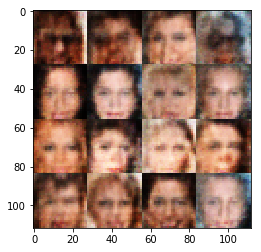

Epoch 0/1 Batch Step 3110... Discriminator Loss: 1.3959... Generator Loss: 0.7546
Epoch 0/1 Batch Step 3120... Discriminator Loss: 1.3848... Generator Loss: 0.7791
Epoch 0/1 Batch Step 3130... Discriminator Loss: 1.4106... Generator Loss: 0.7407
Epoch 0/1 Batch Step 3140... Discriminator Loss: 1.3888... Generator Loss: 0.7585
Epoch 0/1 Batch Step 3150... Discriminator Loss: 1.4150... Generator Loss: 0.7747
Epoch 0/1 Batch Step 3160... Discriminator Loss: 1.3808... Generator Loss: 0.7580
Done Training!


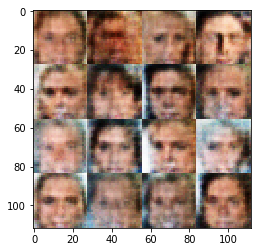

In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.